# ML Based Strategy

[*********************100%***********************]  1 of 1 completed



Model Evaluation:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        48
           1       0.74      0.67      0.71        43

    accuracy                           0.74        91
   macro avg       0.74      0.73      0.73        91
weighted avg       0.74      0.74      0.74        91



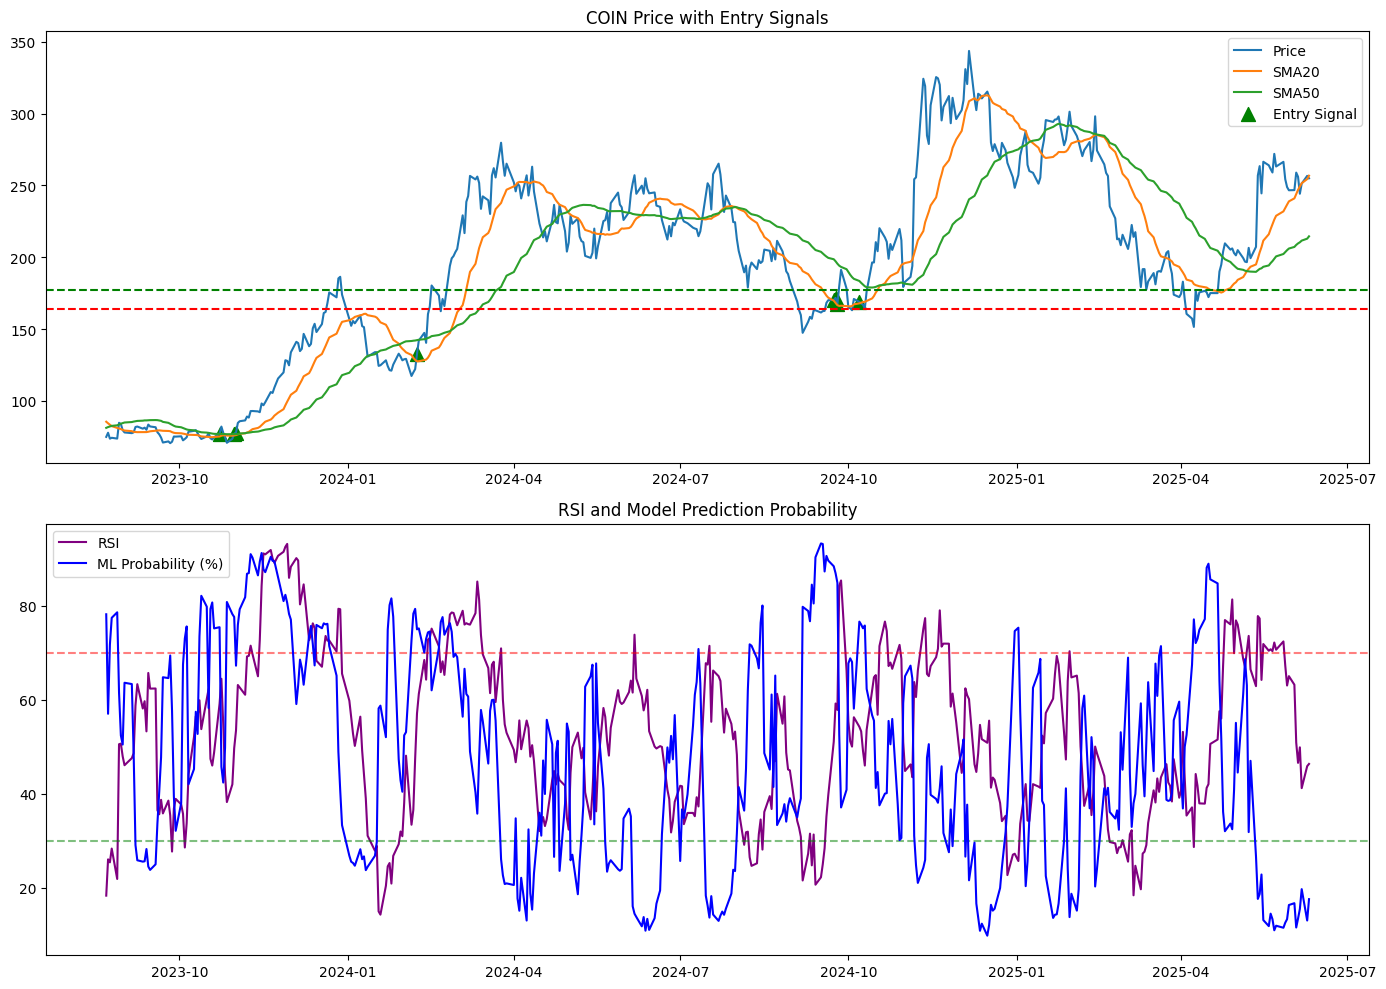


=== Latest Trading Signal ===
Date: 2024-10-07
Entry Price: 168.92
Take Profit: 177.37
Stop Loss: 163.85
ML Confidence: 76.64%


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration
TICKER = "COIN"
YEARS_OF_DATA = 2
TEST_SIZE = 0.2
MIN_SAMPLES = 50
PROFIT_TARGET = 0.05
STOP_LOSS = 0.03

def get_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date, interval = '1d', auto_adjust=False)
    # yfinance started giving multi-index df. Get rid of ticker col.
    df = df.reset_index() 
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    return df

        
def add_technical_indicators(df):
    if df is None or df.empty:
        return df
    
    try:
        # Custom SMA column names
        df['SMA1'] = df['Close'].rolling(window=20).mean()   # SMA20
        df['SMA2'] = df['Close'].rolling(window=50).mean()   # SMA50
        df['SMA3'] = df['Close'].rolling(window=200).mean()  # SMA200

        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        ema12 = df['Close'].ewm(span=12, adjust=False).mean()
        ema26 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = ema12 - ema26
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

        df['Upper_Band'] = df['SMA1'] + (2 * df['Close'].rolling(20).std())
        df['Lower_Band'] = df['SMA1'] - (2 * df['Close'].rolling(20).std())
        df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()

        return df
    except Exception as e:
        print(f"Error adding technical indicators: {e}")
        return df


def prepare_features(df):
    df = df.copy()
    
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['5_day_return'] = df['Close'].pct_change(5)
    df['10_day_return'] = df['Close'].pct_change(10)
    df['Volatility'] = df['Close'].rolling(5).std()

    df['Target'] = 0

    close_prices = df['Close'].values
    for i in range(len(close_prices) - 21):
        current_price = close_prices[i]
        if np.isnan(current_price):
            continue
        future_prices = close_prices[i+1:i+21]
        take_profit = current_price * (1 + PROFIT_TARGET)
        stop_loss = current_price * (1 - STOP_LOSS)

        for price in future_prices:
            if price >= take_profit:
                df.iloc[i, df.columns.get_loc('Target')] = 1
                break
            elif price <= stop_loss:
                break

    df = df.dropna(subset=[
        'RSI', 'SMA1', 'SMA2', 'MACD', 'Signal_Line',
        'Upper_Band', 'Lower_Band', 'Volume_MA20',
        '5_day_return', '10_day_return', 'Volatility'
    ])
    
    return df

if __name__ == "__main__":
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365 * YEARS_OF_DATA)
        data = get_stock_data(TICKER, start_date, end_date)

        if data is None or data.empty:
            raise ValueError("No data retrieved for the given ticker and date range")

        data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

        data = add_technical_indicators(data)
        data = prepare_features(data)

        if len(data) < MIN_SAMPLES:
            raise ValueError(f"Insufficient data samples ({len(data)}). Need at least {MIN_SAMPLES}")

        features = ['RSI', 'SMA1', 'SMA2', 'SMA3', 'MACD', 'Signal_Line', 
            'Upper_Band', 'Lower_Band', 'Volume_MA20',
            '5_day_return', '10_day_return', 'Volatility']

        X = data[features]
        y = data['Target']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf = RandomForestClassifier(n_estimators=200, random_state=42,
                                     class_weight='balanced', max_depth=5)
        clf.fit(X_train_scaled, y_train)

        y_pred = clf.predict(X_test_scaled)
        print("\nModel Evaluation:")
        print(classification_report(y_test, y_pred))

        data['ML_Probability'] = clf.predict_proba(scaler.transform(X))[:, 1]

        data['Entry_Signal'] = np.where(
            (data['ML_Probability'] > 0.65) &
            (data['RSI'] < 60) &
            (data['Close'] > data['SMA1']), 1, 0)

        data['Take_Profit'] = data['Close'] * (1 + PROFIT_TARGET)
        data['Stop_Loss'] = data['Close'] * (1 - STOP_LOSS)

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        print("Please check your data and feature calculations")

    # === Plotting ===
    plt.figure(figsize=(14, 10))

    # Price chart
    plt.subplot(2, 1, 1)
    plt.plot(data['Close'], label='Price')
    plt.plot(data['SMA1'], label='SMA20')
    plt.plot(data['SMA2'], label='SMA50')
    entry_signals = data[data['Entry_Signal'] == 1]
    plt.scatter(entry_signals.index, entry_signals['Close'], marker='^', color='green', label='Entry Signal', s=100)

    if not entry_signals.empty:
        last_signal = entry_signals.iloc[-1]
        plt.axhline(y=last_signal['Take_Profit'], color='green', linestyle='--')
        plt.axhline(y=last_signal['Stop_Loss'], color='red', linestyle='--')

    plt.title(f'{TICKER} Price with Entry Signals')
    plt.legend()

    # RSI + Probability
    plt.subplot(2, 1, 2)
    plt.plot(data['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', alpha=0.5)
    plt.axhline(30, linestyle='--', color='green', alpha=0.5)

    if 'ML_Probability' in data.columns:
        plt.plot(data['ML_Probability'] * 100, label='ML Probability (%)', color='blue')

    plt.legend()
    plt.title('RSI and Model Prediction Probability')
    plt.tight_layout()
    plt.show()

    # === Trading Signal Output ===
    if not entry_signals.empty:
        print("\n=== Latest Trading Signal ===")
        print(f"Date: {last_signal.name.date()}")
        print(f"Entry Price: {last_signal['Close']:.2f}")
        print(f"Take Profit: {last_signal['Take_Profit']:.2f}")
        print(f"Stop Loss: {last_signal['Stop_Loss']:.2f}")
        print(f"ML Confidence: {last_signal['ML_Probability']*100:.2f}%")
    else:
        print("\nNo valid entry signals detected.")


## SIMPLE TI Based Strategy

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA1', 'SMA2', 'SMA3',
       'EMA1', 'EMA2', 'EMA3', 'RSI', 'RSI2', 'OBV', 'PVT', 'MFI', 'CCI',
       'High-Low', 'High-PrevClose', 'Low-PrevClose', 'TR', '+DM', '-DM',
       'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'ADX',
       'StochRSI', 'StochRSI_D', 'BBm', 'BBu', 'BBl', 'ATR', 'Mom1', 'Mom2',
       'ROC1', 'ROC2', 'buy_volume', 'sell_volume', 'sumBuyVol', 'sumSellVol',
       'Bullish_Engulfing', 'Doji', 'Hammer', 'Hanging_Man', 'Morning_Star',
       'Evening_Star', 'Shooting_Star', 'Three_White_Soldiers',
       'Three_Black_Crows', 'Candlesticks', 'Pivot', 'S1', 'S2', 'R1', 'R2',
       'OBV_MA20'],
      dtype='object')
Total trades: 0


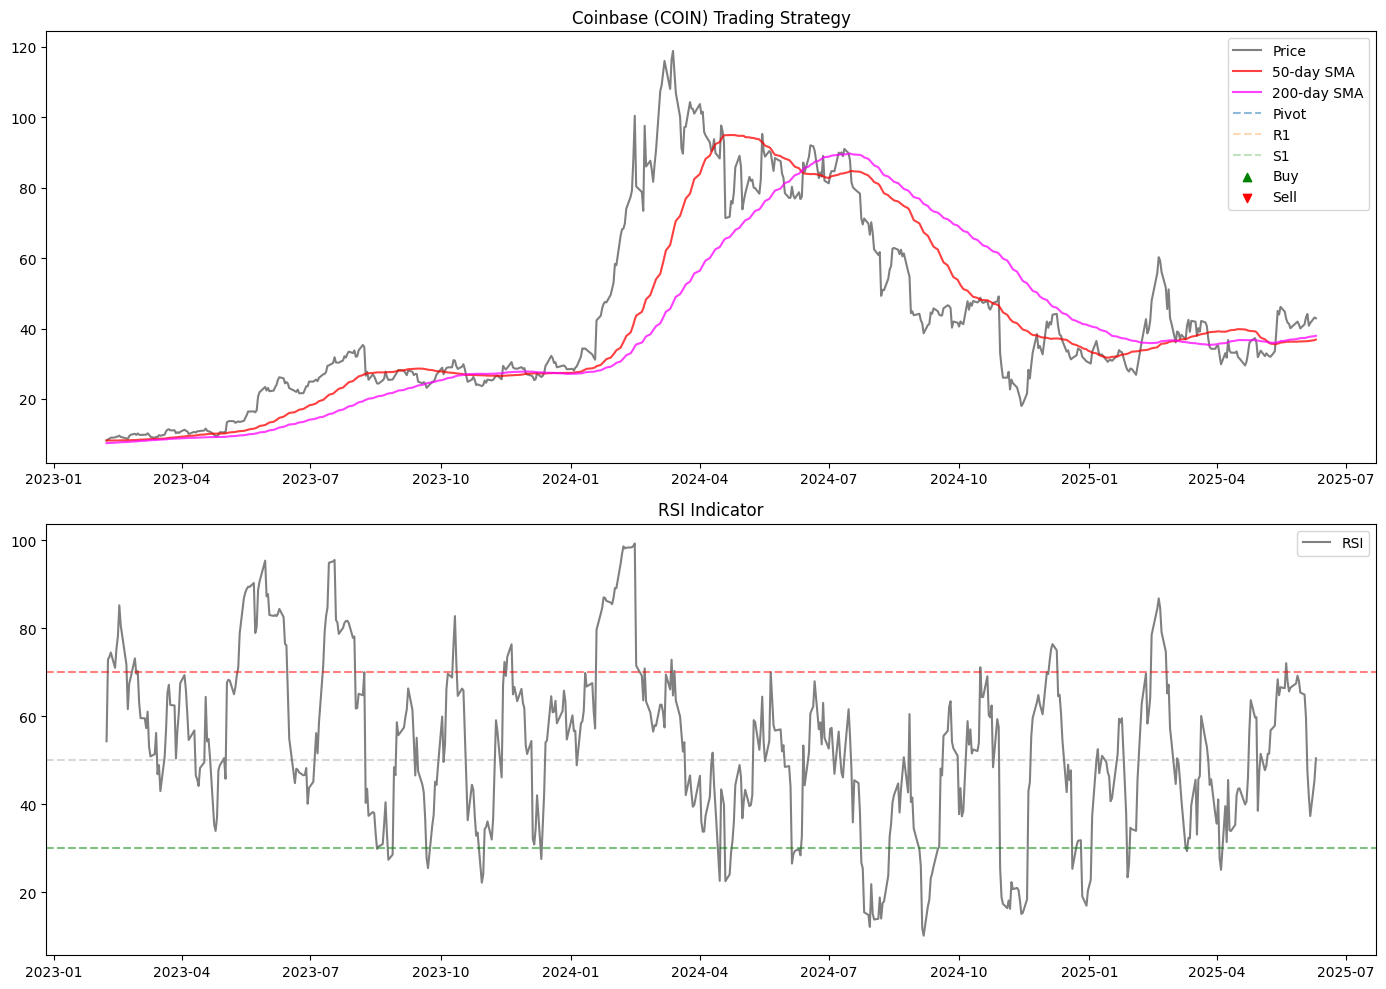


Potential future entry points:
        Date     Price Confidence  \
0 2025-06-11  42.69545     Medium   
1 2025-06-12  42.48090     Medium   
2 2025-06-13  42.26635     Medium   
3 2025-06-14  42.05180     Medium   
4 2025-06-15  41.83725     Medium   

                                              Reason  
0  Potential pullback to 42.70 would meet entry c...  
1  Potential pullback to 42.48 would meet entry c...  
2  Potential pullback to 42.27 would meet entry c...  
3  Potential pullback to 42.05 would meet entry c...  
4  Potential pullback to 41.84 would meet entry c...  


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ta_functions as ta
from ta_pivot_functions import calculate_calc_wk_pvt

# Download 1 year of Coinbase data
ticker = "SMCI"
current_date = datetime.now()
start_date = current_date - timedelta(days=1000)  # Fixed: changed end_date to current_date

data = ta.get_stock_data(ticker, start_date, current_date)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Add technical indicators from your custom functions
data = ta.add_technical_indicators(data)
data = ta.add_candlestickpatterns(data)

# Add weekly pivot points
pivot_points = calculate_calc_wk_pvt(data)
data = data.join(pivot_points)

# Calculate OBV rolling mean before signal generation
data['OBV_MA20'] = data['OBV'].rolling(20).mean()  # Added this line

print(data.columns)

# Define strategy conditions
def generate_signals(df):
    df['Signal'] = 0
    df['Entry_Price'] = np.nan
    df['Exit_Price'] = np.nan
    
    in_position = False
    entry_price = 0
    
    for i in range(1, len(df)):
        current_row = df.iloc[i]
        prev_row = df.iloc[i-1]
        
        # Bullish entry conditions (combining multiple indicators)
        bullish_conditions = (
            (current_row['Close'] > current_row['SMA2']) &  # Above 50-day SMA
            (current_row['SMA2'] > current_row['SMA3']) &  # Golden cross
            (current_row['RSI'] > 50) & (current_row['RSI'] < 70) &  # RSI in favorable range
            (current_row['Close'] > current_row['Pivot']) &  # Above pivot point
            ((current_row['Bullish_Engulfing'] == 1) |  # Bullish candlestick pattern
             (current_row['Hammer'] == 1) | 
             (current_row['Morning_Star'] == 1)) &
            (current_row['OBV'] > current_row['OBV_MA20'])  # Fixed: using pre-calculated rolling mean
        )
        
        if not in_position and bullish_conditions:
            df.loc[df.index[i], 'Signal'] = 1  # Buy signal
            entry_price = current_row['Close']
            df.loc[df.index[i], 'Entry_Price'] = entry_price
            in_position = True
            
        elif in_position:
            current_price = current_row['Close']
            # Exit conditions
            if current_price >= entry_price * 1.025:  # 2.5% profit target
                df.loc[df.index[i], 'Signal'] = -1  # Sell signal
                df.loc[df.index[i], 'Exit_Price'] = current_price
                in_position = False
            elif current_price <= entry_price * 0.98:  # 2% stop loss
                df.loc[df.index[i], 'Signal'] = -1  # Sell signal
                df.loc[df.index[i], 'Exit_Price'] = current_price
                in_position = False
            elif current_row['RSI'] > 70:  # Overbought condition
                df.loc[df.index[i], 'Signal'] = -1
                df.loc[df.index[i], 'Exit_Price'] = current_price
                in_position = False
            elif current_price < current_row['SMA2']:  # Trend reversal
                df.loc[df.index[i], 'Signal'] = -1
                df.loc[df.index[i], 'Exit_Price'] = current_price
                in_position = False
    
    return df


data = generate_signals(data)

# Backtest the strategy
def backtest_strategy(df):
    trades = []
    entry_price = 0
    entry_date = None
    
    for i in range(len(df)):
        if df['Signal'].iloc[i] == 1:  # Buy
            entry_price = df['Close'].iloc[i]
            entry_date = df.index[i]
        elif df['Signal'].iloc[i] == -1 and entry_price != 0:  # Sell
            exit_price = df['Close'].iloc[i]
            exit_date = df.index[i]
            pct_return = (exit_price - entry_price) / entry_price * 100
            holding_days = (exit_date - entry_date).days
            trades.append({
                'Entry_Date': entry_date,
                'Exit_Date': exit_date,
                'Entry_Price': entry_price,
                'Exit_Price': exit_price,
                'Return_%': pct_return,
                'Holding_Days': holding_days
            })
            entry_price = 0
            entry_date = None
    
    return pd.DataFrame(trades)

trades = backtest_strategy(data)

# Print trade results
print(f"Total trades: {len(trades)}")
if len(trades) > 0:
    print(f"Average return: {trades['Return_%'].mean():.2f}%")
    print(f"Success rate (achieved 2.5% target): {len(trades[trades['Return_%'] >= 2.5]) / len(trades) * 100:.2f}%")
    print(f"Average holding period: {trades['Holding_Days'].mean():.1f} days")

# Plot the strategy
plt.figure(figsize=(14, 10))

# Price and indicators
plt.subplot(2, 1, 1)
plt.plot(data['Close'], color = 'black', label='Price', alpha=0.5)
plt.plot(data['SMA2'],  color = 'red', label='50-day SMA', alpha=0.75)
plt.plot(data['SMA3'],  color = 'magenta', label='200-day SMA', alpha=0.75)
plt.plot(data['Pivot'], '--', label='Pivot', alpha=0.5)
plt.plot(data['R1'], '--', label='R1', alpha=0.3)
plt.plot(data['S1'], '--', label='S1', alpha=0.3)

# Buy/sell signals
plt.scatter(data[data['Signal'] == 1].index, 
            data[data['Signal'] == 1]['Close'], 
            label='Buy', marker='^', color='green', alpha=1)
plt.scatter(data[data['Signal'] == -1].index, 
            data[data['Signal'] == -1]['Close'], 
            label='Sell', marker='v', color='red', alpha=1)

plt.title('Coinbase (COIN) Trading Strategy')
plt.legend()

# RSI
plt.subplot(2, 1, 2)
plt.plot(data['RSI'], label='RSI', color='gray')
plt.axhline(70, color='red', linestyle='--', alpha=0.5)
plt.axhline(30, color='green', linestyle='--', alpha=0.5)
plt.axhline(50, color='gray', linestyle='--', alpha=0.3)
plt.title('RSI Indicator')
plt.legend()

plt.tight_layout()
plt.show()

# Generate next potential entry points
def generate_next_entries(df, days_to_lookahead=5):
    current_price = df['Close'].iloc[-1]
    projected_entries = []
    
    # Check current conditions
    current_conditions = {
        'Above SMA50': current_price > df['SMA2'].iloc[-1],
        'Golden Cross': df['SMA2'].iloc[-1] > df['SMA3'].iloc[-1],
        'RSI Range': 50 < df['RSI'].iloc[-1] < 70,
        'Above Pivot': current_price > df['Pivot'].iloc[-1],
        'Bullish Pattern': (df['Bullish_Engulfing'].iloc[-1] == 1) or 
                          (df['Hammer'].iloc[-1] == 1) or 
                          (df['Morning_Star'].iloc[-1] == 1),
        'Volume Confirmation': df['OBV'].iloc[-1] > df['OBV_MA20'].iloc[-1]  # Fixed: using pre-calculated rolling mean
    }
    
    if all(current_conditions.values()):
        projected_entries.append({
            'Date': df.index[-1],
            'Price': current_price,
            'Confidence': 'High',
            'Reason': 'Current conditions meet all entry criteria'
        })
    
    # For demonstration, project potential future entries
    for days_ahead in range(1, days_to_lookahead + 1):
        projected_price = current_price * (1 - 0.005 * days_ahead)  # Example projection
        
        # Check if this price would meet entry criteria
        if projected_price > df['SMA2'].iloc[-1] and df['RSI'].iloc[-1] < 65:
            projected_entries.append({
                'Date': df.index[-1] + timedelta(days=days_ahead),
                'Price': projected_price,
                'Confidence': 'Medium',
                'Reason': f'Potential pullback to {projected_price:.2f} would meet entry criteria'
            })
    
    return pd.DataFrame(projected_entries)

next_entries = generate_next_entries(data)
print("\nPotential future entry points:")
print(next_entries)